In [1]:
import argparse
import time
import numpy as np
import scipy.sparse as sp
import torch
from torch import optim
from model import GCNModelAE, Regularizer
from optimizer import loss_function1
from utils import load_data, mask_test_edges, preprocess_graph, get_roc_score,load_data_with_labels
import matplotlib.pyplot as plt

# Hyper-parameter Setting
Here we present the same setting in our paper WARGA

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=0, help='Random seed.')
parser.add_argument('--epochs', type=int, default=200, help='Number of epochs to train.')
parser.add_argument('--hidden1', type=int, default=32, help='Number of units in the first encoding layer.')
parser.add_argument('--hidden2', type=int, default=16, help='Number of units in the second embedding layer.')
parser.add_argument('--hidden3', type=int, default=16, help='Number of units in the first hidden layer of Regularizer.')
parser.add_argument('--hidden4', type=int, default=64, help='Number of units in the second hidden layer of Regularizer.')
parser.add_argument('--clamp', type=float, default=0.01, help='Weight clamp for Regularizer Parameters.')
parser.add_argument('--lr', type=float, default=0.001, help='Initial learning rate for Generator.')
parser.add_argument('--reglr', type=float, default=0.001, help='Initial learning rate for Regularizer.')
parser.add_argument('--dropout', type=float, default=0., help='Dropout rate (1 - keep probability).')
parser.add_argument('--dataset-str', type=str, default='cora', help='type of dataset.')

args,unknown = parser.parse_known_args()

torch.manual_seed(args.seed)
np.random.seed(args.seed)    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model

In [3]:
def gae_for(args):
    print("Using {} dataset".format(args.dataset_str))
    adj, features,true_labels = load_data_with_labels(args.dataset_str)
    n_nodes, feat_dim = features.shape
    features = features.to(device)
    
    # Store original adjacency matrix (without diagonal entries) for later
    adj_orig = adj
    adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
    adj_orig.eliminate_zeros()
    
    # train-validation-test split
    adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
    adj = adj_train
    
    # Some preprocessing
    adj_norm = preprocess_graph(adj)
    adj_norm = adj_norm.to(device)
    
    adj_label = adj_train + sp.eye(adj_train.shape[0])
    adj_label = torch.FloatTensor(adj_label.toarray())
    adj_label = adj_label.to(device)

    pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
    norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
    
    # Models
    model = GCNModelAE(feat_dim, args.hidden1, args.hidden2, args.dropout).to(device)
    regularizer = Regularizer(args.hidden3, args.hidden2, args.hidden4).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    regularizer_optimizer = optim.Adam(regularizer.parameters(), lr=args.reglr)

    val_ap = []
    train_loss = []
    for epoch in range(args.epochs):
        t = time.time()
        model.train()
        regularizer.train()
        
        # Generate the embeddings
        predicted_labels_prob, emb = model(features, adj_norm)
        
        # Wasserstein Regularizer
        for i in range(1):
            f_z = regularizer(emb).to(device)
            r = torch.normal(0.0, 1.0, [n_nodes, args.hidden2]).to(device)
            f_r = regularizer(r)          
            reg_loss = - f_r.mean() + f_z.mean() 
            
            regularizer_optimizer.zero_grad()
            reg_loss.backward(retain_graph=True)
            regularizer_optimizer.step()
            
            # weight clamp
            for p in regularizer.parameters():
                p.data.clamp_(-args.clamp, args.clamp)

        # Update the Generator
        f_z = regularizer(emb)  
        generator_loss = -f_z.mean()       
        loss = loss_function1(preds=predicted_labels_prob, labels=adj_label,
                             norm=norm, pos_weight=torch.tensor(pos_weight))
        loss = loss + generator_loss
        optimizer.zero_grad()
        loss.backward()
        cur_loss = loss.item()
        optimizer.step()
        
        # Print Validation results every 10 epochs
        if epoch%10 == 0:
            hidden_emb = emb.cpu().data.numpy()
            roc_curr, ap_curr = get_roc_score(hidden_emb, adj_orig, val_edges, val_edges_false)
            print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(cur_loss))
            print("val_ap=", "{:.5f}".format(ap_curr))  
            print("time=", "{:.5f}".format(time.time() - t))
            val_ap.append(ap_curr)
            train_loss.append(cur_loss)
        
    print("Optimization Finished!")
    
    # Plot the learning curve
    fig = plt.figure(figsize=(30,10))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    ax1.plot(train_loss, label='Training loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(frameon=False)

    ax2.plot(val_ap, label='Validation Average Precision Score',color='Red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AP')
    ax2.legend(frameon=False)

    plt.show()
    
    # Testing results
    hidden_emb = emb.cpu().data.numpy()
    roc_score, ap_score = get_roc_score(hidden_emb, adj_orig, test_edges, test_edges_false)
    print("The Last Epoch's Results are:")
    print('Test ROC score: ' + str(roc_score))
    print('Test AP score: ' + str(ap_score))
    
    return roc_score, ap_score

# Run

Seed 0
Using cora dataset
Epoch: 0001 train_loss= 0.78678
val_ap= 0.70048
time= 0.58082
Epoch: 0011 train_loss= 0.77188
val_ap= 0.73789
time= 0.06782
Epoch: 0021 train_loss= 0.72901
val_ap= 0.80494
time= 0.06035
Epoch: 0031 train_loss= 0.65388
val_ap= 0.82456
time= 0.06981
Epoch: 0041 train_loss= 0.58776
val_ap= 0.82779
time= 0.05585
Epoch: 0051 train_loss= 0.55358
val_ap= 0.84347
time= 0.05984
Epoch: 0061 train_loss= 0.53391
val_ap= 0.86450
time= 0.06981
Epoch: 0071 train_loss= 0.52039
val_ap= 0.88134
time= 0.05784
Epoch: 0081 train_loss= 0.51162
val_ap= 0.89428
time= 0.07480
Epoch: 0091 train_loss= 0.50456
val_ap= 0.90197
time= 0.06937
Epoch: 0101 train_loss= 0.49887
val_ap= 0.90712
time= 0.06084
Epoch: 0111 train_loss= 0.49496
val_ap= 0.91172
time= 0.06383
Epoch: 0121 train_loss= 0.49222
val_ap= 0.91355
time= 0.07580
Epoch: 0131 train_loss= 0.48994
val_ap= 0.91425
time= 0.06194
Epoch: 0141 train_loss= 0.48783
val_ap= 0.91539
time= 0.06583
Epoch: 0151 train_loss= 0.48575
val_ap= 0.91

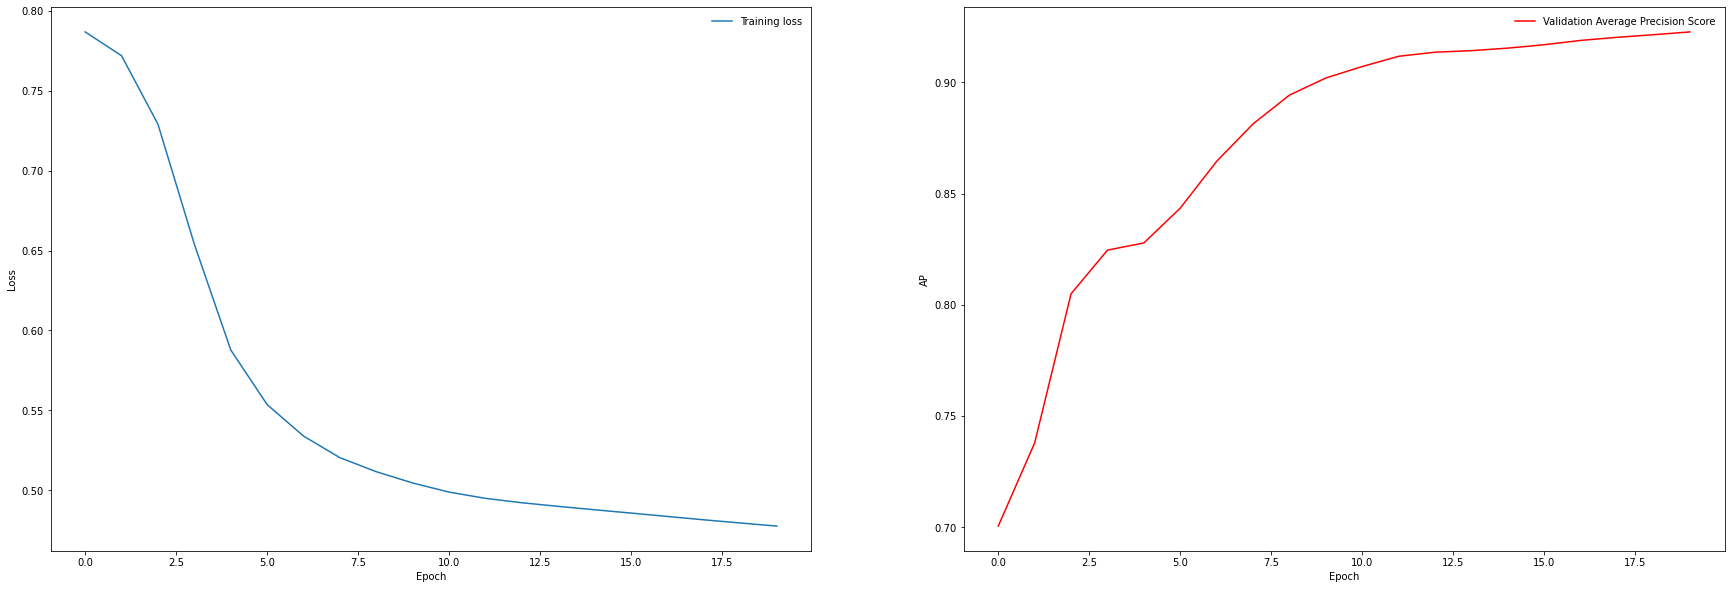

The Last Epoch's Results are:
Test ROC score: 0.929578834043258
Test AP score: 0.9373495496285346
Seed 1
Using cora dataset
Epoch: 0001 train_loss= 0.78310
val_ap= 0.71704
time= 0.05855
Epoch: 0011 train_loss= 0.74236
val_ap= 0.75993
time= 0.07279
Epoch: 0021 train_loss= 0.68570
val_ap= 0.83912
time= 0.07181
Epoch: 0031 train_loss= 0.60571
val_ap= 0.86837
time= 0.07979
Epoch: 0041 train_loss= 0.54086
val_ap= 0.88296
time= 0.07081
Epoch: 0051 train_loss= 0.50594
val_ap= 0.89573
time= 0.06981
Epoch: 0061 train_loss= 0.49418
val_ap= 0.89702
time= 0.06682
Epoch: 0071 train_loss= 0.48284
val_ap= 0.90784
time= 0.07023
Epoch: 0081 train_loss= 0.47599
val_ap= 0.91818
time= 0.08278
Epoch: 0091 train_loss= 0.47127
val_ap= 0.92341
time= 0.05785
Epoch: 0101 train_loss= 0.46700
val_ap= 0.92568
time= 0.05286
Epoch: 0111 train_loss= 0.46306
val_ap= 0.92668
time= 0.07181
Epoch: 0121 train_loss= 0.45933
val_ap= 0.92783
time= 0.06682
Epoch: 0131 train_loss= 0.45588
val_ap= 0.92954
time= 0.07290
Epoch: 0

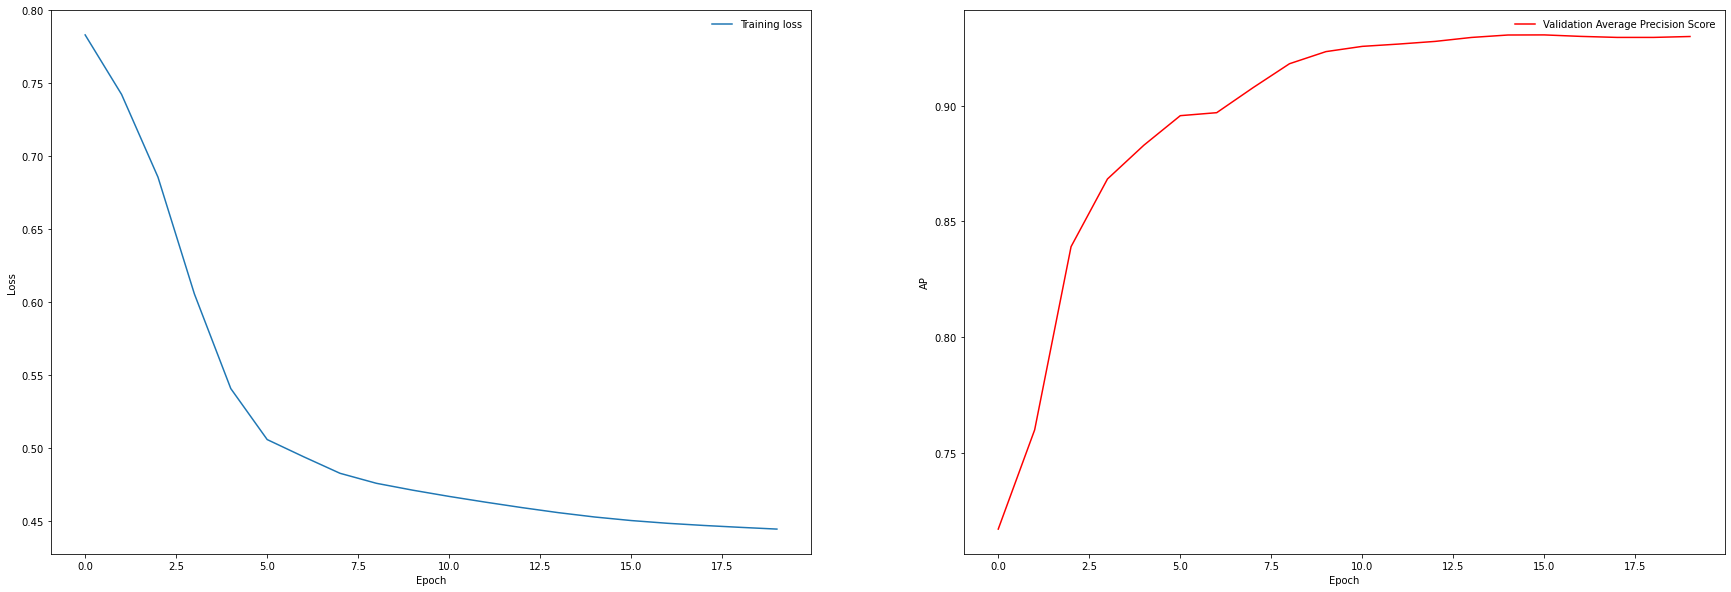

The Last Epoch's Results are:
Test ROC score: 0.9310730964357341
Test AP score: 0.9394075000573161
Seed 2
Using cora dataset
Epoch: 0001 train_loss= 0.78826
val_ap= 0.73191
time= 0.07979
Epoch: 0011 train_loss= 0.74061
val_ap= 0.74910
time= 0.07979
Epoch: 0021 train_loss= 0.68979
val_ap= 0.82942
time= 0.06881
Epoch: 0031 train_loss= 0.61077
val_ap= 0.85310
time= 0.07580
Epoch: 0041 train_loss= 0.53537
val_ap= 0.85560
time= 0.08178
Epoch: 0051 train_loss= 0.49793
val_ap= 0.87169
time= 0.07181
Epoch: 0061 train_loss= 0.47766
val_ap= 0.88825
time= 0.05685
Epoch: 0071 train_loss= 0.46467
val_ap= 0.90153
time= 0.06887
Epoch: 0081 train_loss= 0.45493
val_ap= 0.91420
time= 0.07730
Epoch: 0091 train_loss= 0.44852
val_ap= 0.92017
time= 0.07480
Epoch: 0101 train_loss= 0.44392
val_ap= 0.92282
time= 0.07181
Epoch: 0111 train_loss= 0.44057
val_ap= 0.92484
time= 0.06183
Epoch: 0121 train_loss= 0.43796
val_ap= 0.92619
time= 0.06981
Epoch: 0131 train_loss= 0.43579
val_ap= 0.92716
time= 0.07132
Epoch: 

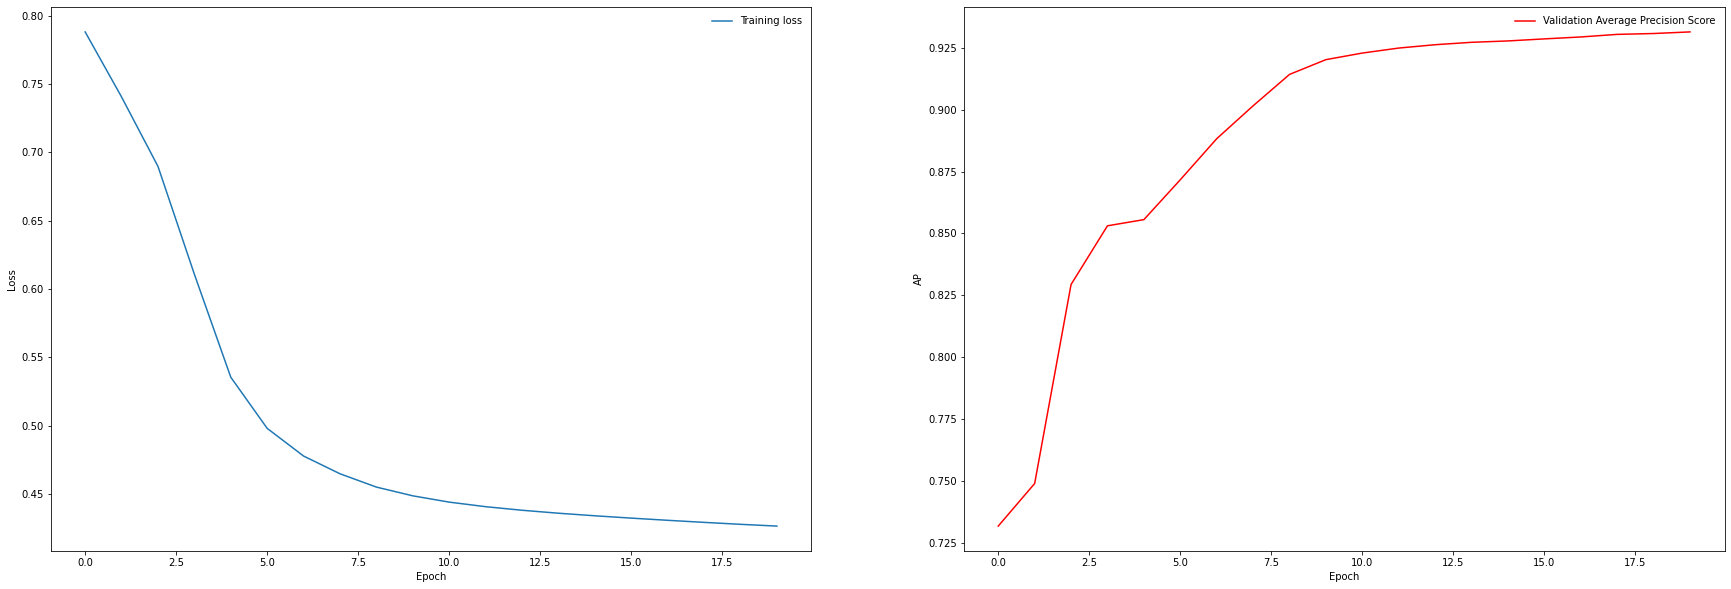

The Last Epoch's Results are:
Test ROC score: 0.9331794663142847
Test AP score: 0.939186615836546
Seed 3
Using cora dataset
Epoch: 0001 train_loss= 0.78052
val_ap= 0.71148
time= 0.07811
Epoch: 0011 train_loss= 0.73987
val_ap= 0.75289
time= 0.06898
Epoch: 0021 train_loss= 0.68727
val_ap= 0.83669
time= 0.05386
Epoch: 0031 train_loss= 0.60494
val_ap= 0.84842
time= 0.08078
Epoch: 0041 train_loss= 0.54636
val_ap= 0.86627
time= 0.05984
Epoch: 0051 train_loss= 0.51505
val_ap= 0.88609
time= 0.07281
Epoch: 0061 train_loss= 0.50207
val_ap= 0.89504
time= 0.06582
Epoch: 0071 train_loss= 0.48883
val_ap= 0.90595
time= 0.07381
Epoch: 0081 train_loss= 0.47938
val_ap= 0.91578
time= 0.08178
Epoch: 0091 train_loss= 0.47184
val_ap= 0.92231
time= 0.07181
Epoch: 0101 train_loss= 0.46602
val_ap= 0.92547
time= 0.07082
Epoch: 0111 train_loss= 0.46152
val_ap= 0.92631
time= 0.08577
Epoch: 0121 train_loss= 0.45781
val_ap= 0.92771
time= 0.06633
Epoch: 0131 train_loss= 0.45456
val_ap= 0.92956
time= 0.06882
Epoch: 0

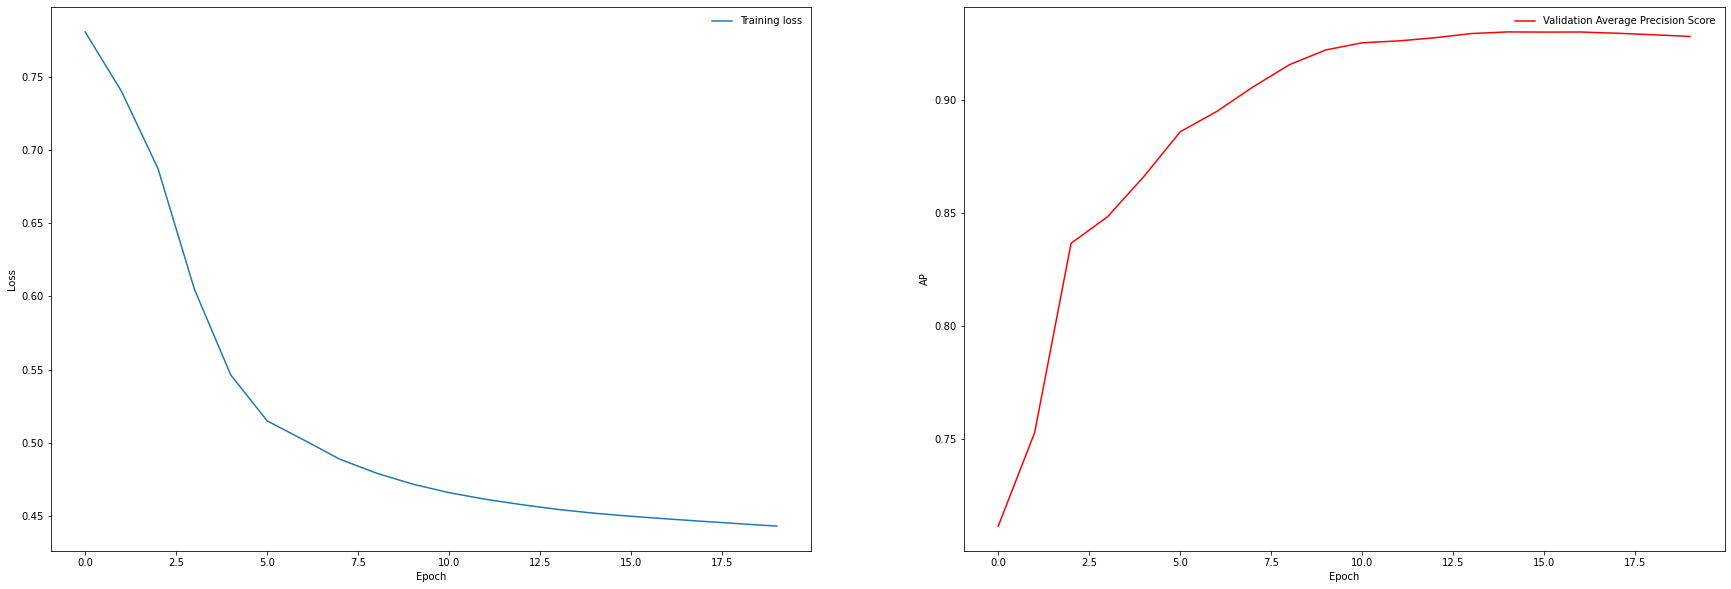

The Last Epoch's Results are:
Test ROC score: 0.9239906527586245
Test AP score: 0.93408055396711
Seed 4
Using cora dataset
Epoch: 0001 train_loss= 0.77640
val_ap= 0.74828
time= 0.06791
Epoch: 0011 train_loss= 0.70631
val_ap= 0.75661
time= 0.08078
Epoch: 0021 train_loss= 0.65488
val_ap= 0.82491
time= 0.07232
Epoch: 0031 train_loss= 0.57821
val_ap= 0.83990
time= 0.07879
Epoch: 0041 train_loss= 0.51537
val_ap= 0.85720
time= 0.07879
Epoch: 0051 train_loss= 0.47787
val_ap= 0.89010
time= 0.07380
Epoch: 0061 train_loss= 0.46055
val_ap= 0.90470
time= 0.07779
Epoch: 0071 train_loss= 0.44635
val_ap= 0.91864
time= 0.08115
Epoch: 0081 train_loss= 0.43830
val_ap= 0.92471
time= 0.06184
Epoch: 0091 train_loss= 0.43212
val_ap= 0.92686
time= 0.09375
Epoch: 0101 train_loss= 0.42699
val_ap= 0.92909
time= 0.08278
Epoch: 0111 train_loss= 0.42297
val_ap= 0.93162
time= 0.07380
Epoch: 0121 train_loss= 0.41958
val_ap= 0.93392
time= 0.07648
Epoch: 0131 train_loss= 0.41668
val_ap= 0.93576
time= 0.07232
Epoch: 01

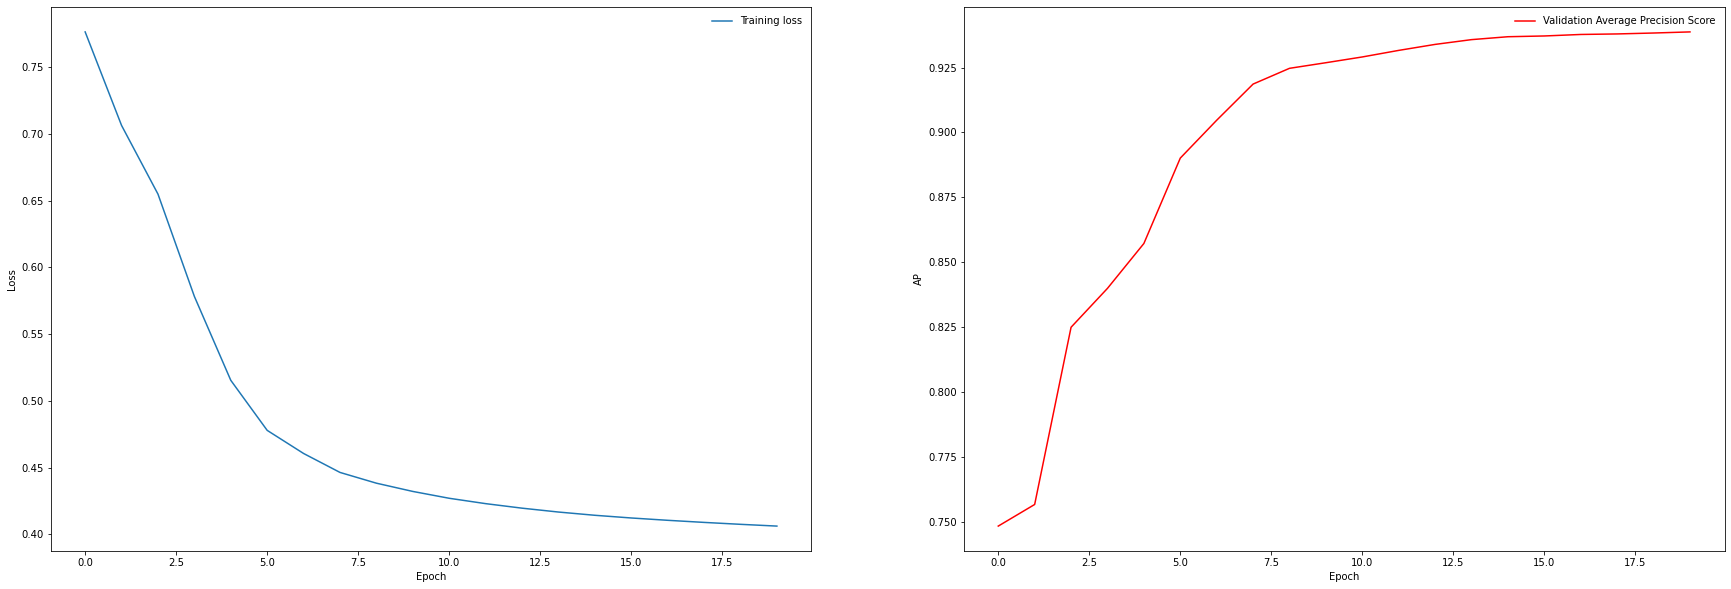

The Last Epoch's Results are:
Test ROC score: 0.9279945558440061
Test AP score: 0.9409917266506594
Seed 5
Using cora dataset
Epoch: 0001 train_loss= 0.78398
val_ap= 0.79718
time= 0.05485
Epoch: 0011 train_loss= 0.71844
val_ap= 0.76685
time= 0.05286
Epoch: 0021 train_loss= 0.66494
val_ap= 0.84571
time= 0.05784
Epoch: 0031 train_loss= 0.58433
val_ap= 0.87403
time= 0.05485
Epoch: 0041 train_loss= 0.51667
val_ap= 0.87919
time= 0.05485
Epoch: 0051 train_loss= 0.48896
val_ap= 0.89136
time= 0.05286
Epoch: 0061 train_loss= 0.46536
val_ap= 0.90606
time= 0.05386
Epoch: 0071 train_loss= 0.45059
val_ap= 0.91027
time= 0.05287
Epoch: 0081 train_loss= 0.44321
val_ap= 0.91214
time= 0.05286
Epoch: 0091 train_loss= 0.43615
val_ap= 0.91865
time= 0.05286
Epoch: 0101 train_loss= 0.43101
val_ap= 0.92245
time= 0.05785
Epoch: 0111 train_loss= 0.42716
val_ap= 0.92480
time= 0.05785
Epoch: 0121 train_loss= 0.42380
val_ap= 0.92706
time= 0.05785
Epoch: 0131 train_loss= 0.42088
val_ap= 0.92881
time= 0.05485
Epoch: 

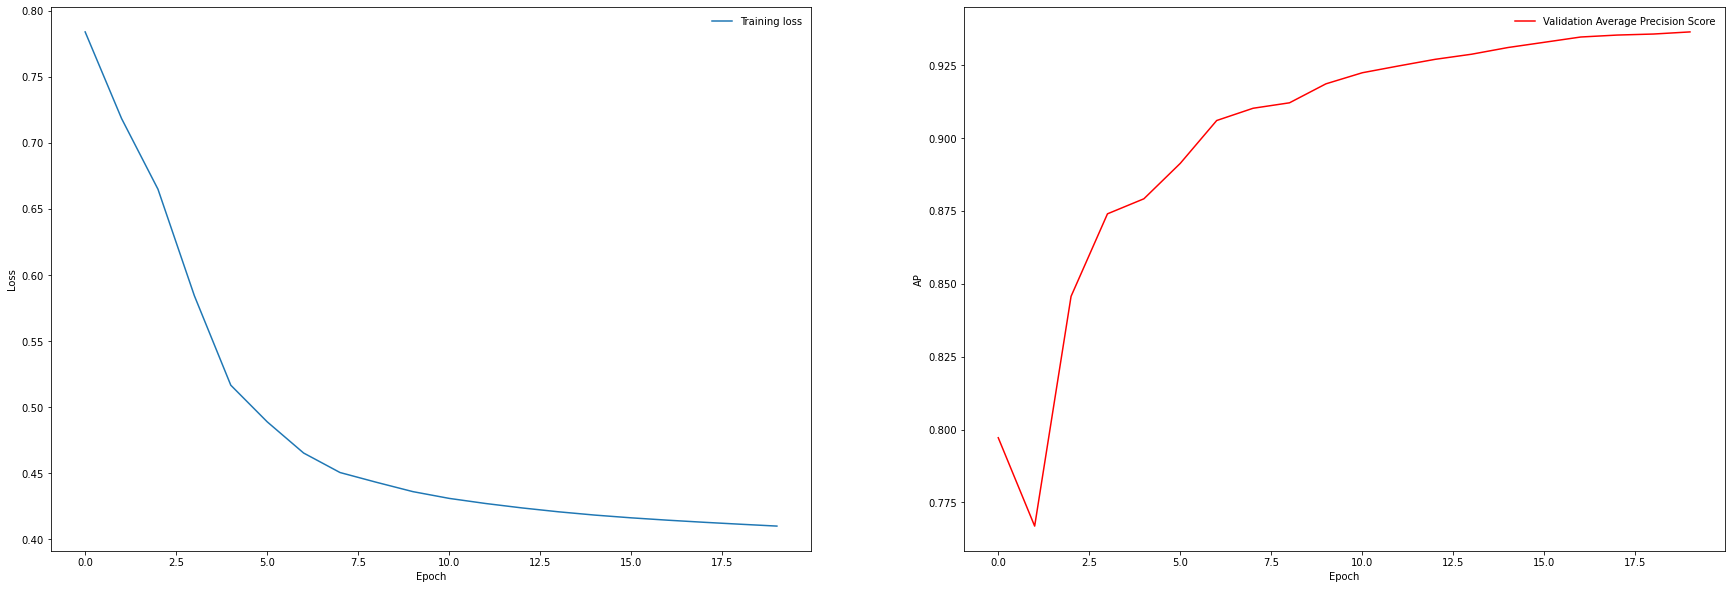

The Last Epoch's Results are:
Test ROC score: 0.9315339773664256
Test AP score: 0.9413695038345372
Seed 6
Using cora dataset
Epoch: 0001 train_loss= 0.77758
val_ap= 0.75672
time= 0.06295
Epoch: 0011 train_loss= 0.70789
val_ap= 0.76800
time= 0.06135
Epoch: 0021 train_loss= 0.64131
val_ap= 0.85907
time= 0.05546
Epoch: 0031 train_loss= 0.54982
val_ap= 0.87328
time= 0.06938
Epoch: 0041 train_loss= 0.49323
val_ap= 0.87540
time= 0.05140
Epoch: 0051 train_loss= 0.47832
val_ap= 0.87975
time= 0.05137
Epoch: 0061 train_loss= 0.46462
val_ap= 0.88677
time= 0.07081
Epoch: 0071 train_loss= 0.45378
val_ap= 0.89677
time= 0.05286
Epoch: 0081 train_loss= 0.44572
val_ap= 0.90284
time= 0.05186
Epoch: 0091 train_loss= 0.43985
val_ap= 0.90769
time= 0.06084
Epoch: 0101 train_loss= 0.43527
val_ap= 0.91028
time= 0.06183
Epoch: 0111 train_loss= 0.43148
val_ap= 0.91281
time= 0.05286
Epoch: 0121 train_loss= 0.42793
val_ap= 0.91529
time= 0.04901
Epoch: 0131 train_loss= 0.42476
val_ap= 0.91627
time= 0.05186
Epoch: 

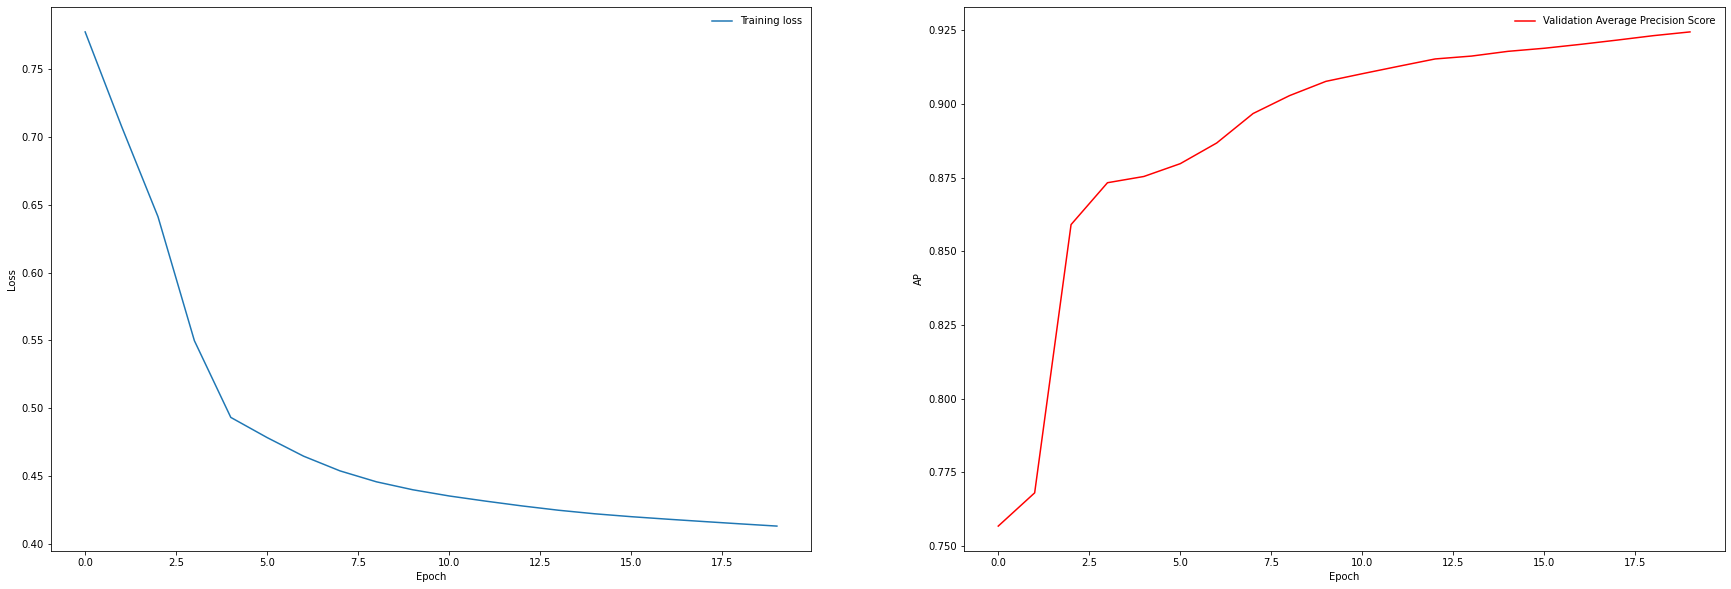

The Last Epoch's Results are:
Test ROC score: 0.926082620108091
Test AP score: 0.9360832705152662
Seed 7
Using cora dataset
Epoch: 0001 train_loss= 0.78154
val_ap= 0.76601
time= 0.05704
Epoch: 0011 train_loss= 0.72768
val_ap= 0.73978
time= 0.05677
Epoch: 0021 train_loss= 0.67714
val_ap= 0.84077
time= 0.05484
Epoch: 0031 train_loss= 0.59645
val_ap= 0.84996
time= 0.05487
Epoch: 0041 train_loss= 0.52780
val_ap= 0.85515
time= 0.06109
Epoch: 0051 train_loss= 0.49268
val_ap= 0.87592
time= 0.05901
Epoch: 0061 train_loss= 0.47634
val_ap= 0.89136
time= 0.05286
Epoch: 0071 train_loss= 0.46630
val_ap= 0.89939
time= 0.05186
Epoch: 0081 train_loss= 0.45830
val_ap= 0.90451
time= 0.06084
Epoch: 0091 train_loss= 0.45161
val_ap= 0.90554
time= 0.05785
Epoch: 0101 train_loss= 0.44612
val_ap= 0.90683
time= 0.05086
Epoch: 0111 train_loss= 0.44148
val_ap= 0.90793
time= 0.05685
Epoch: 0121 train_loss= 0.43746
val_ap= 0.90961
time= 0.06472
Epoch: 0131 train_loss= 0.43405
val_ap= 0.91218
time= 0.05585
Epoch: 0

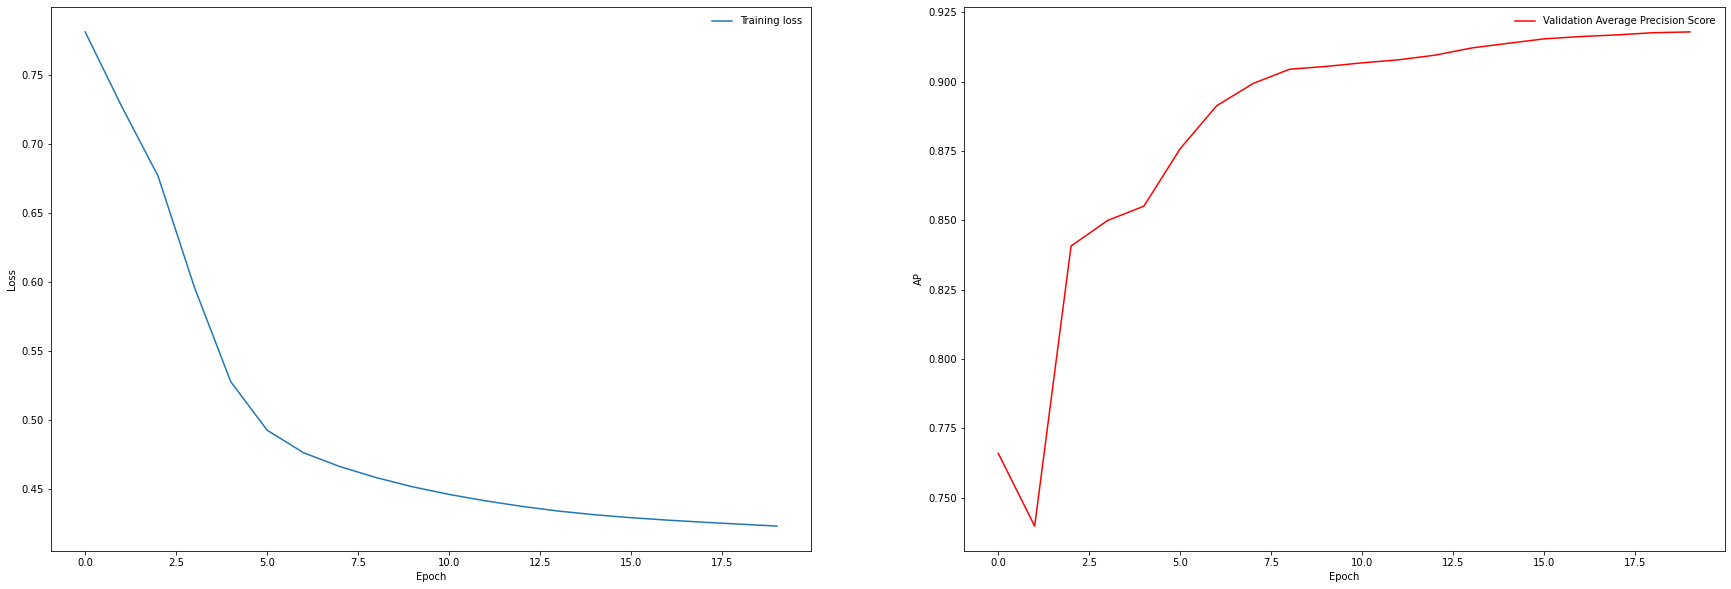

The Last Epoch's Results are:
Test ROC score: 0.9307958477508651
Test AP score: 0.939880980386731
Seed 8
Using cora dataset
Epoch: 0001 train_loss= 0.78124
val_ap= 0.75277
time= 0.06582
Epoch: 0011 train_loss= 0.72996
val_ap= 0.77126
time= 0.05386
Epoch: 0021 train_loss= 0.65375
val_ap= 0.84011
time= 0.05237
Epoch: 0031 train_loss= 0.57114
val_ap= 0.83475
time= 0.05286
Epoch: 0041 train_loss= 0.53073
val_ap= 0.84968
time= 0.05195
Epoch: 0051 train_loss= 0.51222
val_ap= 0.86958
time= 0.04887
Epoch: 0061 train_loss= 0.49472
val_ap= 0.89275
time= 0.05186
Epoch: 0071 train_loss= 0.48233
val_ap= 0.91102
time= 0.05385
Epoch: 0081 train_loss= 0.47346
val_ap= 0.92129
time= 0.05386
Epoch: 0091 train_loss= 0.46725
val_ap= 0.92715
time= 0.05785
Epoch: 0101 train_loss= 0.46283
val_ap= 0.93035
time= 0.04887
Epoch: 0111 train_loss= 0.45932
val_ap= 0.93222
time= 0.05174
Epoch: 0121 train_loss= 0.45643
val_ap= 0.93357
time= 0.05235
Epoch: 0131 train_loss= 0.45404
val_ap= 0.93445
time= 0.05884
Epoch: 0

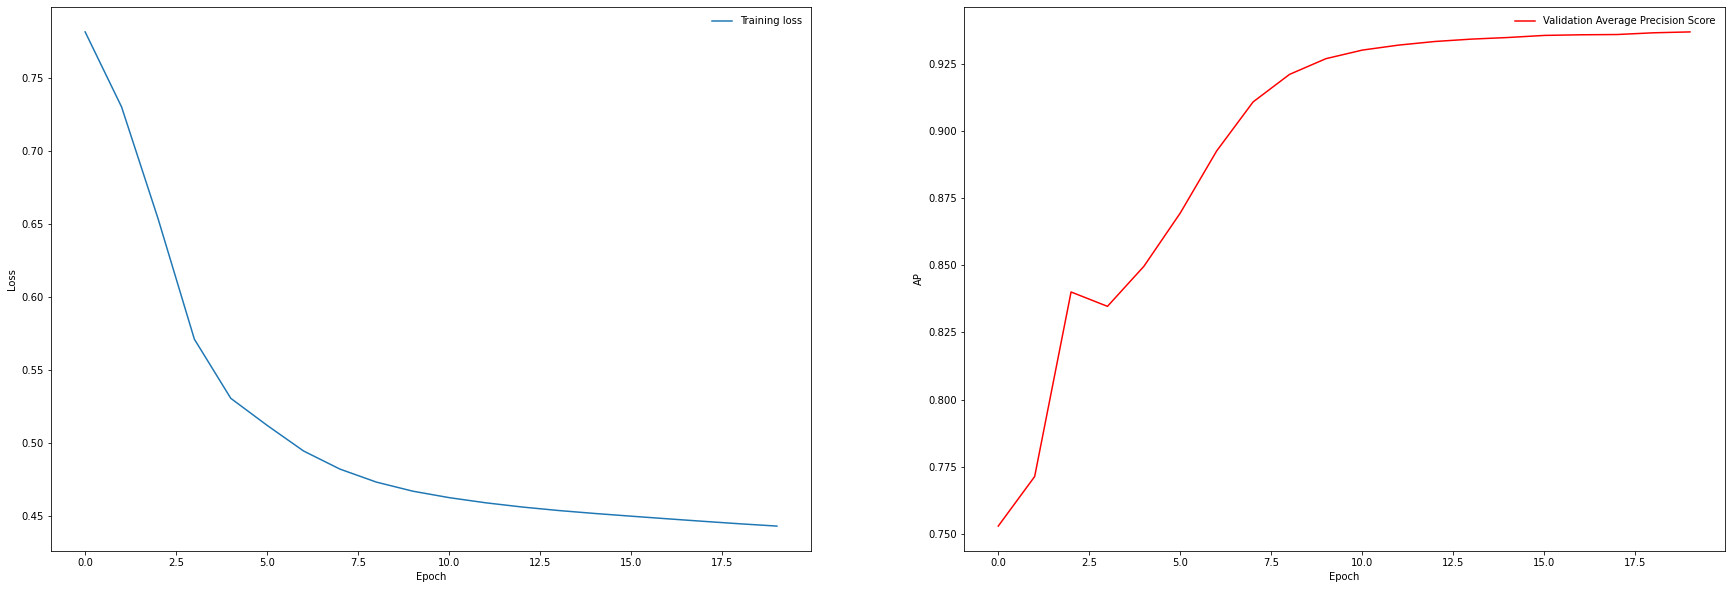

The Last Epoch's Results are:
Test ROC score: 0.9317140089799768
Test AP score: 0.9407381929408106
Seed 9
Using cora dataset
Epoch: 0001 train_loss= 0.77550
val_ap= 0.74314
time= 0.05736
Epoch: 0011 train_loss= 0.72506
val_ap= 0.76341
time= 0.05547
Epoch: 0021 train_loss= 0.68553
val_ap= 0.83652
time= 0.05186
Epoch: 0031 train_loss= 0.60599
val_ap= 0.88240
time= 0.05336
Epoch: 0041 train_loss= 0.52987
val_ap= 0.88967
time= 0.05884
Epoch: 0051 train_loss= 0.49315
val_ap= 0.90082
time= 0.05286
Epoch: 0061 train_loss= 0.48099
val_ap= 0.90488
time= 0.05485
Epoch: 0071 train_loss= 0.47186
val_ap= 0.90834
time= 0.05685
Epoch: 0081 train_loss= 0.46506
val_ap= 0.91327
time= 0.06035
Epoch: 0091 train_loss= 0.45954
val_ap= 0.91610
time= 0.05984
Epoch: 0101 train_loss= 0.45507
val_ap= 0.91848
time= 0.06582
Epoch: 0111 train_loss= 0.45151
val_ap= 0.91963
time= 0.05735
Epoch: 0121 train_loss= 0.44846
val_ap= 0.92137
time= 0.05086
Epoch: 0131 train_loss= 0.44588
val_ap= 0.92197
time= 0.05386
Epoch: 

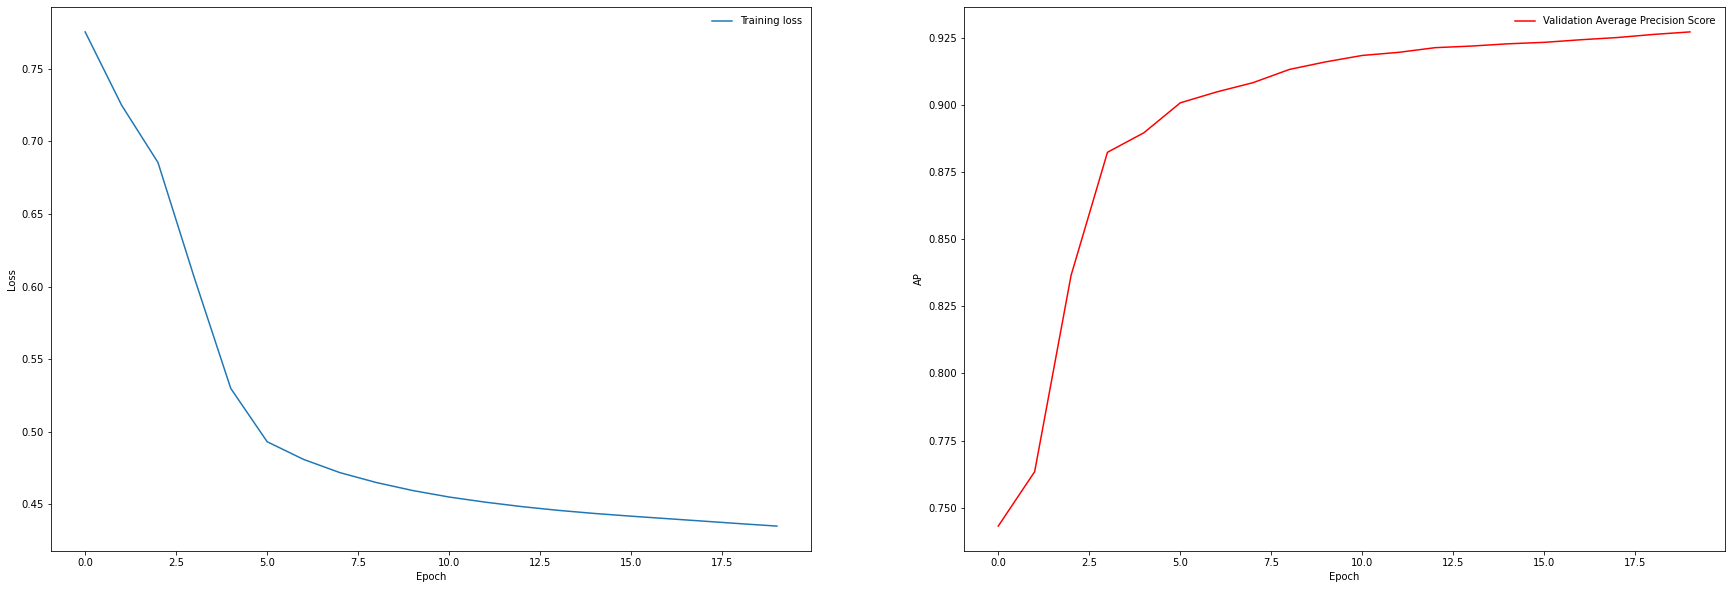

The Last Epoch's Results are:
Test ROC score: 0.925002430426783
Test AP score: 0.9354014822719563
[0.929578834043258, 0.9310730964357341, 0.9331794663142847, 0.9239906527586245, 0.9279945558440061, 0.9315339773664256, 0.926082620108091, 0.9307958477508651, 0.9317140089799768, 0.925002430426783]
mean test AUC is 0.9290945490028049  std  0.002993650314542074
[0.9373495496285346, 0.9394075000573161, 0.939186615836546, 0.93408055396711, 0.9409917266506594, 0.9413695038345372, 0.9360832705152662, 0.939880980386731, 0.9407381929408106, 0.9354014822719563]
mean test AP is  0.9384489376089468  std  0.002427441558890743


In [4]:
once = False

if __name__ == '__main__':
    if once == True:
        gae_for(args)
    
    else:
        test_roc = []
        test_ap = []
        
        # Run with 10 different random seeds
        for seed in range(10):
            print('Seed',seed)
            args.seed = seed
            torch.manual_seed(args.seed)
            roc_score, ap_score = gae_for(args)
            test_roc.append(roc_score)
            test_ap.append(ap_score)
        
        # show results by mean and std
        print(test_roc)
        print('mean test AUC is',np.mean(test_roc),' std ', np.std(test_roc))
        print(test_ap)
        print('mean test AP is ',np.mean(test_ap), ' std ', np.std(test_ap))